# pyISC Example: Using pyISC as Classifier
In this example, we compare the pyISC classifer to using an example taken from the Scikit-learn machine learning library (http://scikit-learn.org).

In [1]:
import pyisc

For creating a classifier without first creating an anomaly detector, we can create an instance of pyisc.SklearnClassifier similarly to how we create an anomaly detector in the <a href="pyISC_classification_example.ipynb">previous example</a>:

In [2]:
classifier = pyisc.SklearnClassifier(    
    component_models=[
        pyisc.P_PoissonOnesided(1,0), # columns 1 and 0
        pyisc.P_Poisson(2,0), # columns 2 and 0
        pyisc.P_Gaussian(3) # column 3
    ])

The classifier is compatible with the Scikit-learn classifiers so we can use it in the code below that is adapted from the Scikit-learn project documentation ( http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html ). In the code below, the pyISC classifier is initialized with a two-variate Gaussian distribution.

Automatically created module for IPython interactive environment
Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
pyISC Classifier
Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
pyISC Classifier
Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
pyISC Classifier


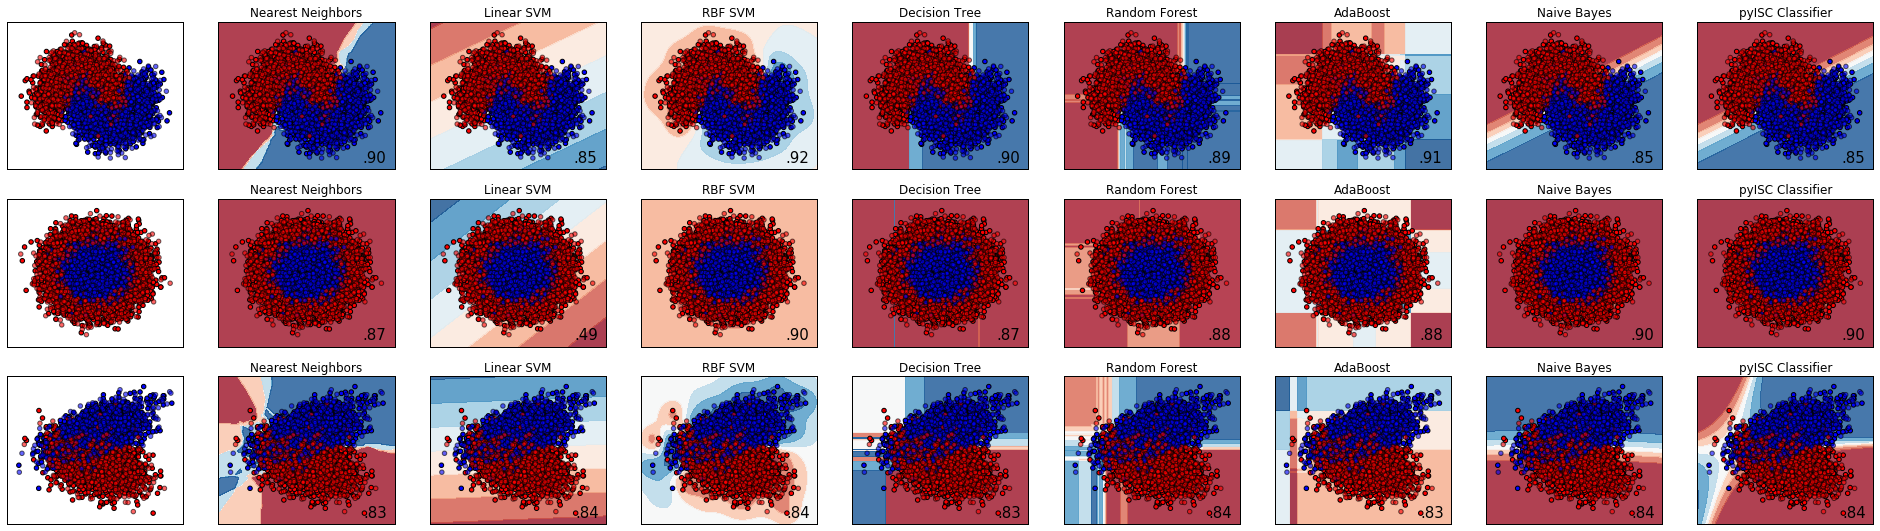

In [6]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified for pyISC by Tomas Olsson
# License: BSD 3 clause

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from pyisc import SklearnClassifier, P_Gaussian
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", #"Linear Discriminant Analysis",
         #"Quadratic Discriminant Analysis", 
         "pyISC Classifier", "pyISC Classifier clust"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
#    LinearDiscriminantAnalysis(),
#    QuadraticDiscriminantAnalysis(),
    SklearnClassifier(P_Gaussian([0,1]))
]

n_samples = 5000

X, y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(n_samples=n_samples,noise=0.3, random_state=0),
            make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        print name
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98);


To the left in the figure above, we can see the data points with two classes (red and blue colors). To the right, we see the decision borders for the different classifiers with the classification accuracy in the lower right corner. 
As can be seen, the pyISC classifier has a comparable performance to the best classifiers. Not surprisingly, the performance with respect to the decision borders is equal to the Naive Bayes classifier in the upper two examples, since they both use Gaussian distributions, although it differs quite remarkally in the last row because pyISC also considers the covariance between variables.

In [ ]:
SklearnClassifier?